### Demo script: fits CTDS to multi-region simulated data

This script creates a cell type dynamical system (CTDS) and simulated data from it, assuming two regions where both regions obey Dale's law, and the cross-region connections between these regions are excitatory only. We then fit a new CTDS model to data generated from this model. We also show how to add custom constraints on the dynamics matrix. (By default, CTDS assumes Dale's law within region, and FOF-ADS cross region connections akin to the paper so that region 1 has only excitatory connections to region 2 but there are no constraints on communication in the other direction.) 

We have defined a new emission class and a new observations class within SSM for the CTDS model. They can be accessed by setting emissions and dynamics to "gaussian_ctds" when creating a CTDS object, as we show below. 

In [11]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import jax.random as jr

from models.ctds_model import CTDSModel
from models.components.ctds_dynamics import CTDSDynamics
from models.components.ctds_emissions import CTDSEmissions

#from utils.initialization import load_config
#from models.utils.simulator import simulate_ctds_data
#from utils.visualization import plot_latents_by_region
#random seed for reproducibility
key = jr.PRNGKey(10)

#### Simulate data from a CTDS 

In this section, we generate data from a CTDS model. We will show how to create the model, and visualize example parameters of the model.

In [12]:
"""
import yaml

with open("../config/ctds_config.yaml", "r") as f:
    config = yaml.safe_load(f)

"""

num_regions = 2 # number of regions in the network
num_neurons_per_region = 20 
num_neurons_per_region_per_cell_type = num_neurons_per_region // 2 # number of neurons per cell type in each region

num_latent_per_cell_type = 2 # assuming same number of latents per cell type
cell_identity=jnp.array([0,1,2])  #unknown, excite, inhib
list_of_dimensions = jnp.ones((num_regions, 2), dtype=int) * num_latent_per_cell_type #creates a JAX array of shape (num_regions, 2) filled with 1s.
print(list_of_dimensions)


[[2 2]
 [2 2]]


##### Set the model parameters

We set the model parameters to obey biological constraints. The dynamics $A$ obeys Dale's law within-region and has only excitatory connections between regions. The emission $C$ is block-diagonal and positive with each block corresponding to one cell-type within a region.

In [14]:
# create an array with identities of each region as integers starting from 0
region_identity = jnp.zeros(num_neurons_per_region*num_regions, dtype=int)
for i in range(num_regions):
    region_identity = region_identity.at[ i * num_neurons_per_region : (i + 1) * num_neurons_per_region].set(i)



A= CTDSDynamics(list_of_dimensions, within_region=True)
A.build()


C=CTDSEmissions(40,len(list_of_dimensions),cell_identity, region_identity,list_of_dimensions, key)
print(list_of_dimensions)
print(C.__dict__)
C.build()

model=CTDSModel(10,3,100,cell_identity, list_of_dimensions, region_identity)
#model.initialize_params()

"""
A = create_dynamics_matrix(list_of_dimensions)

# create the emission matrix
C = np.zeros((num_regions*num_neurons_per_region, np.sum(list_of_dimensions)))
num_neurons_per_region_per_type = num_neurons_per_region//2
for i in range(num_regions):
    excitatory_latents, inhibitory_latents = list_of_dimensions[i]
    # put this into a block-diagonal matrix
    region_C = np.zeros((num_neurons_per_region, excitatory_latents + inhibitory_latents))
    # set the excitatory block
    if excitatory_latents > 0:
        region_C[:num_neurons_per_region_per_type,:excitatory_latents] = np.random.rand(num_neurons_per_region_per_type, excitatory_latents)
    if inhibitory_latents > 0:
        region_C[num_neurons_per_region_per_type:num_neurons_per_region,excitatory_latents:excitatory_latents+inhibitory_latents] = np.random.rand(num_neurons_per_region_per_type, inhibitory_latents)

    total_latent_previous_regions = np.sum(list_of_dimensions[:i])
    C[i*num_neurons_per_region:(i+1)*num_neurons_per_region, total_latent_previous_regions:total_latent_previous_regions+excitatory_latents+inhibitory_latents] = region_C # this matrix should be block-diagonal and non-negative
    

Q = np.random.randn(np.sum(list_of_dimensions), np.sum(list_of_dimensions))
Q = Q.T@Q + np.identity(np.sum(list_of_dimensions))
Q = Q/(np.max(Q)*1000)

# R should be num_neurons x num_neurons, diagonal with positive entries
R = np.diag(np.random.rand(num_regions*num_neurons_per_region) + 0.1)/1000

# check that Q and R are PD
assert np.all(np.linalg.eigvals(Q) > 0), "Q is not PD"
assert np.all(np.linalg.eigvals(R) > 0), "R is not PD"
"""

TypeError: CTDSEmissions.initialize() missing 1 required positional argument: 'Y'

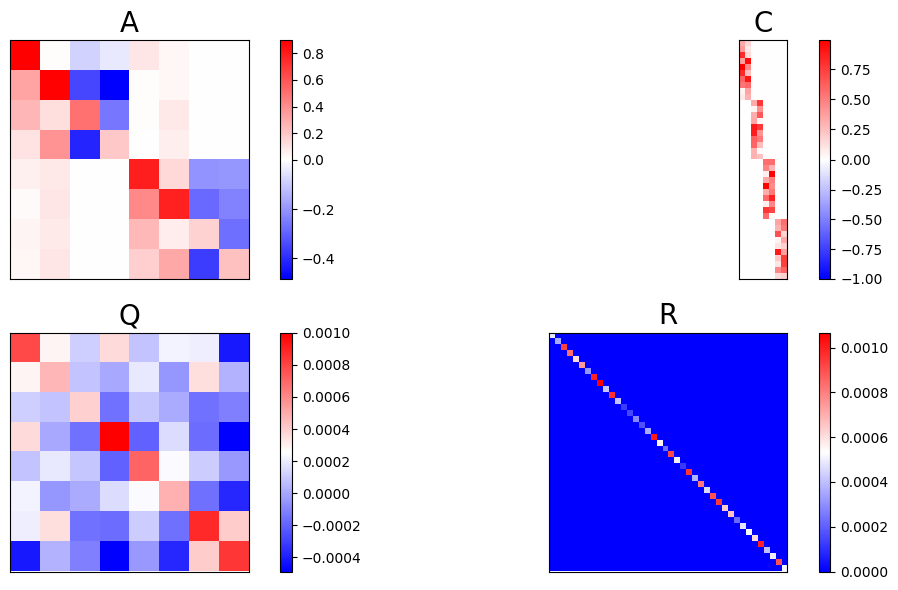

In [12]:
#plot_and_save_parameters(A, C, Q, R, None)


##### Create a CTDS model

A CTDS model can be created using "gaussian_ctds" emissions (constrains emissions to be block-diag and positive), and the "gaussian_ctds" dynamics class (puts Dale's law + excitatory cross-region constraints by default, although they can be custom as shown later). 
1. Defining a CTDS model requires cell-identities in the form of an integer numpy array of size (number of neurons,) where 0 is used for unknown cell-classes and will be inferred by the model, the known cell classes are labeled as integers >=1. 
2. CTDS also needs an integer np array called list_of_dimensions of shape (number of regions) x (number of cell types), that contains latent dimensions for each cell type in a region. 
3. Finally, when modeling data from multiple regions, we optionally provide region identity to the model which is also a numpy integer array of size number of neurons, containing the region identity of each neuron, labeled >=0.

In [13]:
# create an array with identities of each region as integers starting from 0
region_identity = np.zeros(num_neurons_per_region*num_regions, dtype=int)
for i in range(num_regions):
    region_identity[i*num_neurons_per_region:(i+1)*num_neurons_per_region] = i

# create an array with identities of each cell type as integers starting from 1, important to note we use 0 for unknown cell-types
cell_type_identity = np.zeros(num_neurons_per_region*num_regions, dtype=int)
for i in range(num_regions):
    cell_type_this_region = np.ones(num_neurons_per_region, dtype=int)
    cell_type_this_region[num_neurons_per_region_per_type:] = 2
    cell_type_identity[i*num_neurons_per_region:(i+1)*num_neurons_per_region] = cell_type_this_region

num_total_latents = int(np.sum(list_of_dimensions))
#print(cell_type_identity)
#print(region_identity)

In [14]:
# Creating CTDS requires providing cell_identity, and list_of_dimensions. cell_identity should be 0 for unknown cell-types, and labeled>0 for known cell-types. region_identity is optional otherwise model assumes all neurons are from the same region. "gaussian_ctds" is the new class we defined independently for dynamics and observations to handle cell-type specific dynamics and observations.
ctds = ssm.LDS(N=num_regions*num_neurons_per_region, D=num_total_latents, M=0, dynamics="gaussian_ctds", emissions="gaussian_ctds", emission_kwargs=dict(cell_identity=cell_type_identity, region_identity=region_identity, list_of_dimensions=list_of_dimensions), dynamics_kwargs=dict(list_of_dimensions=list_of_dimensions)) 
# set the dynamics matrix
ctds.dynamics.As[0] = A
# set the emission matrix
ctds.emissions.Cs[0] = C
# set the noise covariance
ctds.dynamics._sqrt_Sigmas[0] = np.linalg.cholesky(Q)
ctds.emissions.inv_etas[0] = R
ctds.emissions.ds[0] = 0
ctds.dynamics.bs[0] = 0
assert np.allclose(ctds.dynamics.Sigmas[0], Q), "Q is not set correctly"

AttributeError: module 'ssm' has no attribute 'LDS'

In [ ]:
# generate data from model
# now let's simulate data from this model
T = 100
num_trials = 50
datas = []
for i in range(num_trials):
    true_states, data = ctds.sample(T, prefix=None)
    datas.append(data)

# plot and save the true states for region 1 and region 2 separately
plt.figure(figsize=(8, 3))
plt.subplot(121)
for i in range(np.sum(list_of_dimensions[0])):
    plt.plot(true_states[:, i], color = 'k', alpha = 0.5)
plt.title('true states region 1')
plt.xlabel('time')
plt.yticks([0], '0')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.subplot(122)
for i in range(np.sum(list_of_dimensions[1])):
    plt.plot(true_states[:, i+np.sum(list_of_dimensions[0])], color = 'k', alpha = 0.5)
plt.title('true states region 2')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('time')
plt.yticks([0], '0')

In [ ]:
# divide into train and test datasets
num_train_trials = int(0.8*num_trials)
train_datas = datas[:num_train_trials]
test_datas = datas[num_train_trials:]

# compute LLs for the test and train datasets
true_model_ll = ctds.log_likelihood(test_datas)
true_model_train_ll = ctds.log_likelihood(train_datas)

#### Fit a new CTDS to this generated dataset

In [ ]:
new_ctds = ssm.LDS(N=num_regions*num_neurons_per_region, D=num_total_latents, M=0, dynamics="gaussian_ctds", emissions="gaussian_ctds", emission_kwargs=dict(cell_identity=cell_type_identity, region_identity=region_identity, list_of_dimensions=list_of_dimensions), dynamics_kwargs=dict(list_of_dimensions=list_of_dimensions)) 

##### Custom constraints on dynamics

Here we show how to set custom constraints on teh dynamics matrix $A$ if we want to deviate from the default constraints (which are set per FOF-ADS communication, as described in the paper.)

In [ ]:
# By default the model assumes Dale's law for within-region dynamics and FOF-ADS style cross-region dynamics (with only E projections from FOF to ADS, and no constraints on projections from ADS to FOF), however these can be changed using custom functions. For example, here we want both cross-region connections to be excitatory only and set the inhibitory latents to zero, let's set that.

def custom_across_region_constraints(W):
        """ Setup Dale's constraints for the weights W assuming E and I cell classes, and cross-region constraints """
        total_latents = np.sum(list_of_dimensions)
        across_region_constraints = []
        latents_region_1 = np.sum(list_of_dimensions[0])
        d_e_region_1, _ = list_of_dimensions[0]
        d_e_region_2, _ = list_of_dimensions[1]
        across_region_constraints = [W[latents_region_1:total_latents, 0:d_e_region_1]>=0, W[latents_region_1:total_latents, d_e_region_1:latents_region_1]==0, W[0:latents_region_1, latents_region_1:latents_region_1+d_e_region_2]>=0, W[0:latents_region_1, latents_region_1+d_e_region_2:total_latents]==0]
        return across_region_constraints   

new_ctds.dynamics.across_region_constraints = custom_across_region_constraints

In [ ]:
# fit this model to generated data
lls,_ = new_ctds.fit(train_datas, method="laplace_em", 
                                     num_iters = 100, initialize=True) # this uses the SSM initialization scheme and fits for 100 iterations

In [ ]:
# compute the log likelihood of the test data
test_log_likelihood = new_ctds.log_likelihood(test_datas)
# plot lls 
plt.figure(figsize=(5, 4))
plt.plot(lls, color = 'k')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('LL', fontsize=15)
plt.xlabel('iteration', fontsize=15)

print(f"True model test LL: {true_model_ll}")
print(f"New model test LL: {test_log_likelihood}")

In [ ]:
# plot learned parameters
A_rec = new_ctds.dynamics.As[0]
C_rec = new_ctds.emissions.Cs[0]
Q_rec = new_ctds.dynamics.Sigmas[0]
R_rec = new_ctds.emissions.inv_etas[0]

# there are non-identifiabilities in the model in terms of latents permuting and scaling of latent / emission spaces, so we need to deal with these
C_rec, A_rec, Q_rec = transform_true_rec(C, C_rec, A_rec, Q_rec, list_of_dimensions, region_identity=region_identity)


plot_and_save_parameters(A_rec, C_rec, Q_rec, R_rec, None)

#### Fitting CTDS with default constraints
Here we demonstrate fitting CTDS with default constraints. The main difference from the previous results will be that the top-right cross-region dynamics (from region 2 to region 1) will no more be constrained to be excitatory only (as is the case with ADS->FOF dynamics). We can see this in the fitted $A$ matrix visualized below.

In [ ]:
# we could also fit a model with default constraints from the paper, that assumes excitatory connections only from FOF to ADS and no constraints on projections from ADS to FOF

new_ctds = ssm.LDS(N=num_regions*num_neurons_per_region, D=num_total_latents, M=0, dynamics="gaussian_ctds", emissions="gaussian_ctds", emission_kwargs=dict(cell_identity=cell_type_identity, region_identity=region_identity, list_of_dimensions=list_of_dimensions), dynamics_kwargs=dict(list_of_dimensions=list_of_dimensions))

# fit this model to generated data
lls,_ = new_ctds.fit(train_datas, method="laplace_em", 
                                     num_iters = 100, initialize=True) # this uses the SSM initialization scheme and fits for 100 iterations 

# compute the log likelihood of the test data
test_log_likelihood = new_ctds.log_likelihood(test_datas)

print(f"True model test LL: {true_model_ll}")
print(f"New model test LL: {test_log_likelihood}")

# plot learned parameters
A_rec = new_ctds.dynamics.As[0]
C_rec = new_ctds.emissions.Cs[0]
Q_rec = new_ctds.dynamics.Sigmas[0]
R_rec = new_ctds.emissions.inv_etas[0]

# there are non-identifiabilities in the model in terms of latents permuting and scaling of latent / emission spaces, so we need to deal with these
C_rec, A_rec, Q_rec = transform_true_rec(C, C_rec, A_rec, Q_rec, list_of_dimensions, region_identity=region_identity)


plot_and_save_parameters(A_rec, C_rec, Q_rec, R_rec, None)